In this notebook, we are going to use Latent Dirichlet Allocation (LDA) for topic modeling to retrieve topics from 20K different Wikipedia abstracts in an unsuperivsed way.  Click here [here](https://raw.githubusercontent.com/vinid/data/master/dbpedia_sample_abstract_20k_unprep.txt) to download the data.
Check the LDA paper to understand the method:
* Blei, David M., Andrew Y. Ng, and Michael I. Jordan. "Latent dirichlet allocation." the Journal of machine Learning research 3 (2003): 993-1022.


In [1]:
import sys
import re
import nltk
import string
import pandas as pd
import numpy as np
import gensim
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import warnings
import random
from time import time

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

%matplotlib inline

In [2]:
print(sys.version)
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('nltk:',nltk.__version__)
print('gensim:',gensim.__version__)

3.8.8 (default, Feb 24 2021, 13:46:16) 
[Clang 10.0.0 ]
numpy: 1.19.2
pandas: 1.2.3
nltk: 3.5
gensim: 3.8.3


In [3]:
with open("./dbpedia_sample_abstract_20k_unprep.txt", 'r') as fr:
    text = [line.strip() for line in fr.readlines()]

In [4]:
random.shuffle(text)
print('total number of Wikipedia abstracts:',len(text))

total number of Wikipedia abstracts: 20000


In [5]:
# print the first sentence
pprint(text[0])

('Daubrée is a lunar crater that is located to the southwest of the Mare '
 'Serenitatis, just to the west-southwest of the crater Menelaus in the Montes '
 'Haemus range. The small lunar mare Lacus Hiemalis lies along the southwest '
 'rim of Daubrée. This is a horseshoe-shaped formation with the rim open')


### 1. Data cleaning & preprocessing

In [6]:
def cleanPunc(sentence):
    '''Clean a sentence of any punctuation or special characters'''
    cleaned = re.sub(r'[?|!|\'|"|#|”|’]',r'',sentence)
    cleaned = re.sub(r'[.|,|(|)|\|/|-|–]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n","")
    cleaned = re.sub('\s+',' ',cleaned) #replace multiple spaces with a single one
    return cleaned

In [7]:
def preprocess(sentence):
    '''Preprocess text, get rid of special chars, convert to lower, remove stop words.'''
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub('\s+',' ',sentence)
    sentence = sentence.replace("\n","")
    sentence = sentence.lower()
    sentence = [word for word in sentence.split() if word not in stopwords and len(word) > 1]
    sentence = [lemmatizer.lemmatize(word) for word in sentence]
    return ' '.join(sentence)

In [8]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords = set(stopwords)

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [9]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [10]:
cleaned_text = list(map(cleanPunc, text))
cleaned_text = list(map(preprocess, cleaned_text))

In [11]:
# print the first sentence again
print('A raw sentence:\n')
pprint(text[0])
print('\nThe same sentence after pre-processing:\n')
pprint(cleaned_text[0])

A raw sentence:

('Daubrée is a lunar crater that is located to the southwest of the Mare '
 'Serenitatis, just to the west-southwest of the crater Menelaus in the Montes '
 'Haemus range. The small lunar mare Lacus Hiemalis lies along the southwest '
 'rim of Daubrée. This is a horseshoe-shaped formation with the rim open')

The same sentence after pre-processing:

('daubr lunar crater located southwest mare serenitatis west southwest crater '
 'menelaus monte haemus range small lunar mare lacus hiemalis lie along '
 'southwest rim daubr horseshoe shaped formation rim open')


In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/isra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Split sentences into tokens (words)

In [13]:
from nltk import word_tokenize
tokens = list(map(word_tokenize, cleaned_text))

In [14]:
df=pd.DataFrame()
df['abstract']=text
df['tokens']=tokens
df.head()

abstract  \
0                                     Daubrée is a lunar crater that is located to the southwest of the Mare Serenitatis, just to the west-southwest of the crater Menelaus in the Montes Haemus range. The small lunar mare Lacus Hiemalis lies along the southwest rim of Daubrée. This is a horseshoe-shaped formation with the rim open   
1            Vyshhorodsko-Darnytska Line (Ukrainian: Вишгородсько-Дарницька лінія) is a proposed fifth line to the Kiev Metro system serving the Ukrainian capital Kiev. The line is proposed to begin near the Taras Shevchenko Square in the city's north, and is to run south, connecting to the system's four other lines (one of which   
2  Chemical species are atoms, molecules, molecular fragments, ions, etc., subjected to a chemical process or to a measurement. Generally, a chemical species is an ensemble of chemically identical molecular entities that can explore the same set of molecular energy levels on a characteristic or delineated time scale. The term may   
3                          This is a list of electoral districts or ridings in Canada for the Canadian federal election of 1953, 1957, 1958, 1962, 1963, and 1965. For the first time, each of Canada's territories would return one member each, instead of one member for both. Electoral Districts are constituencies that elect Members   
4                                                    Nazareno Cruz and the Wolf (Spanish: Nazareno Cruz y el lobo) is a 1975 Argentine fantasy film directed by Leonardo Favio and starring Juan José Camero and Alfredo Alcón. The story works as an adaptation of the classical myth of the Lobizón, and it has become a classic film. It   

                                                                                                                                                                                                                                                                                      tokens  
0                                                    [daubr, lunar, crater, located, southwest, mare, serenitatis, west, southwest, crater, menelaus, monte, haemus, range, small, lunar, mare, lacus, hiemalis, lie, along, southwest, rim, daubr, horseshoe, shaped, formation, rim, open]  
1                                             [vyshhorodsko, darnytska, line, ukrainian, proposed, fifth, line, kiev, metro, system, serving, ukrainian, capital, kiev, line, proposed, begin, near, tara, shevchenko, square, city, north, run, south, connecting, system, four, line, one]  
2  [chemical, specie, atom, molecule, molecular, fragment, ion, etc, subjected, chemical, process, measurement, generally, chemical, specie, ensemble, chemically, identical, molecular, entity, explore, set, molecular, energy, level, characteristic, delineated, time, scale, term, may]  
3                                                                               [list, electoral, district, riding, canada, canadian, federal, election, first, time, canada, territory, would, return, one, member, instead, one, member, electoral, district, constituency, elect, member]  
4                                                          [nazareno, cruz, wolf, spanish, nazareno, cruz, el, lobo, argentine, fantasy, film, directed, leonardo, favio, starring, juan, jos, camero, alfredo, alc, story, work, adaptation, classical, myth, lobiz, become, classic, film]

In [15]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(df["tokens"])
dictionary

In [16]:
len(dictionary)

67811

#### Filter out tokens that appear in less than `no_below` abstracts (absolute number) or more than `no_above` fraction of total abstracts

In [17]:
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [18]:
len(dictionary)

3506

####  Convert `document` into the bag-of-words (BoW) format = list of `(token_id, token_count)` tuples.

In [19]:
corpus = [dictionary.doc2bow(abstract) for abstract in df["tokens"]]

### 2. Apply LDA model

In [20]:
from gensim import models

# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=48, random_state=43,
                chunksize=200, passes=10,update_every=5)



In [21]:
#pprint(lda_model.print_topics(num_words=10))
for i, t in enumerate(range(lda_model.num_topics)): 
    topic_dict = dict(lda_model.show_topic(t, 10)) # topic - top 10 words dictionary
    print(str(t+1),':',list(topic_dict.keys()))

1 : ['school', 'high', 'played', 'hockey', 'carolina', 'student', 'ice', 'retired', 'wisconsin', 'public']
2 : ['born', 'summer', 'olympics', 'european', 'medal', 'competed', 'world', 'bridge', 'cross', 'championship']
3 : ['india', 'community', 'indian', 'office', 'included', 'post', 'florida', 'upper', 'unincorporated', 'culture']
4 : ['state', 'united', 'county', 'park', 'list', 'national', 'foot', 'township', 'pennsylvania', 'creek']
5 : ['research', 'class', 'point', 'sport', 'navy', 'match', 'ship', 'complex', 'michigan', 'winning']
6 : ['company', 'including', 'music', 'co', 'based', 'production', 'various', 'studied', 'several', 'founded']
7 : ['force', 'air', 'range', 'white', 'unit', 'washington', 'theatre', 'los', 'movie', 'police']
8 : ['college', 'university', 'study', 'education', 'institute', 'nation', 'take', 'museum', 'lived', 'library']
9 : ['organization', 'bank', 'site', 'parliament', 'act', 'left', 'national', 'largest', 'body', 'constituency']
10 : ['river', 'chin

### 3. Topic visualization

Plot word cloud for each topic

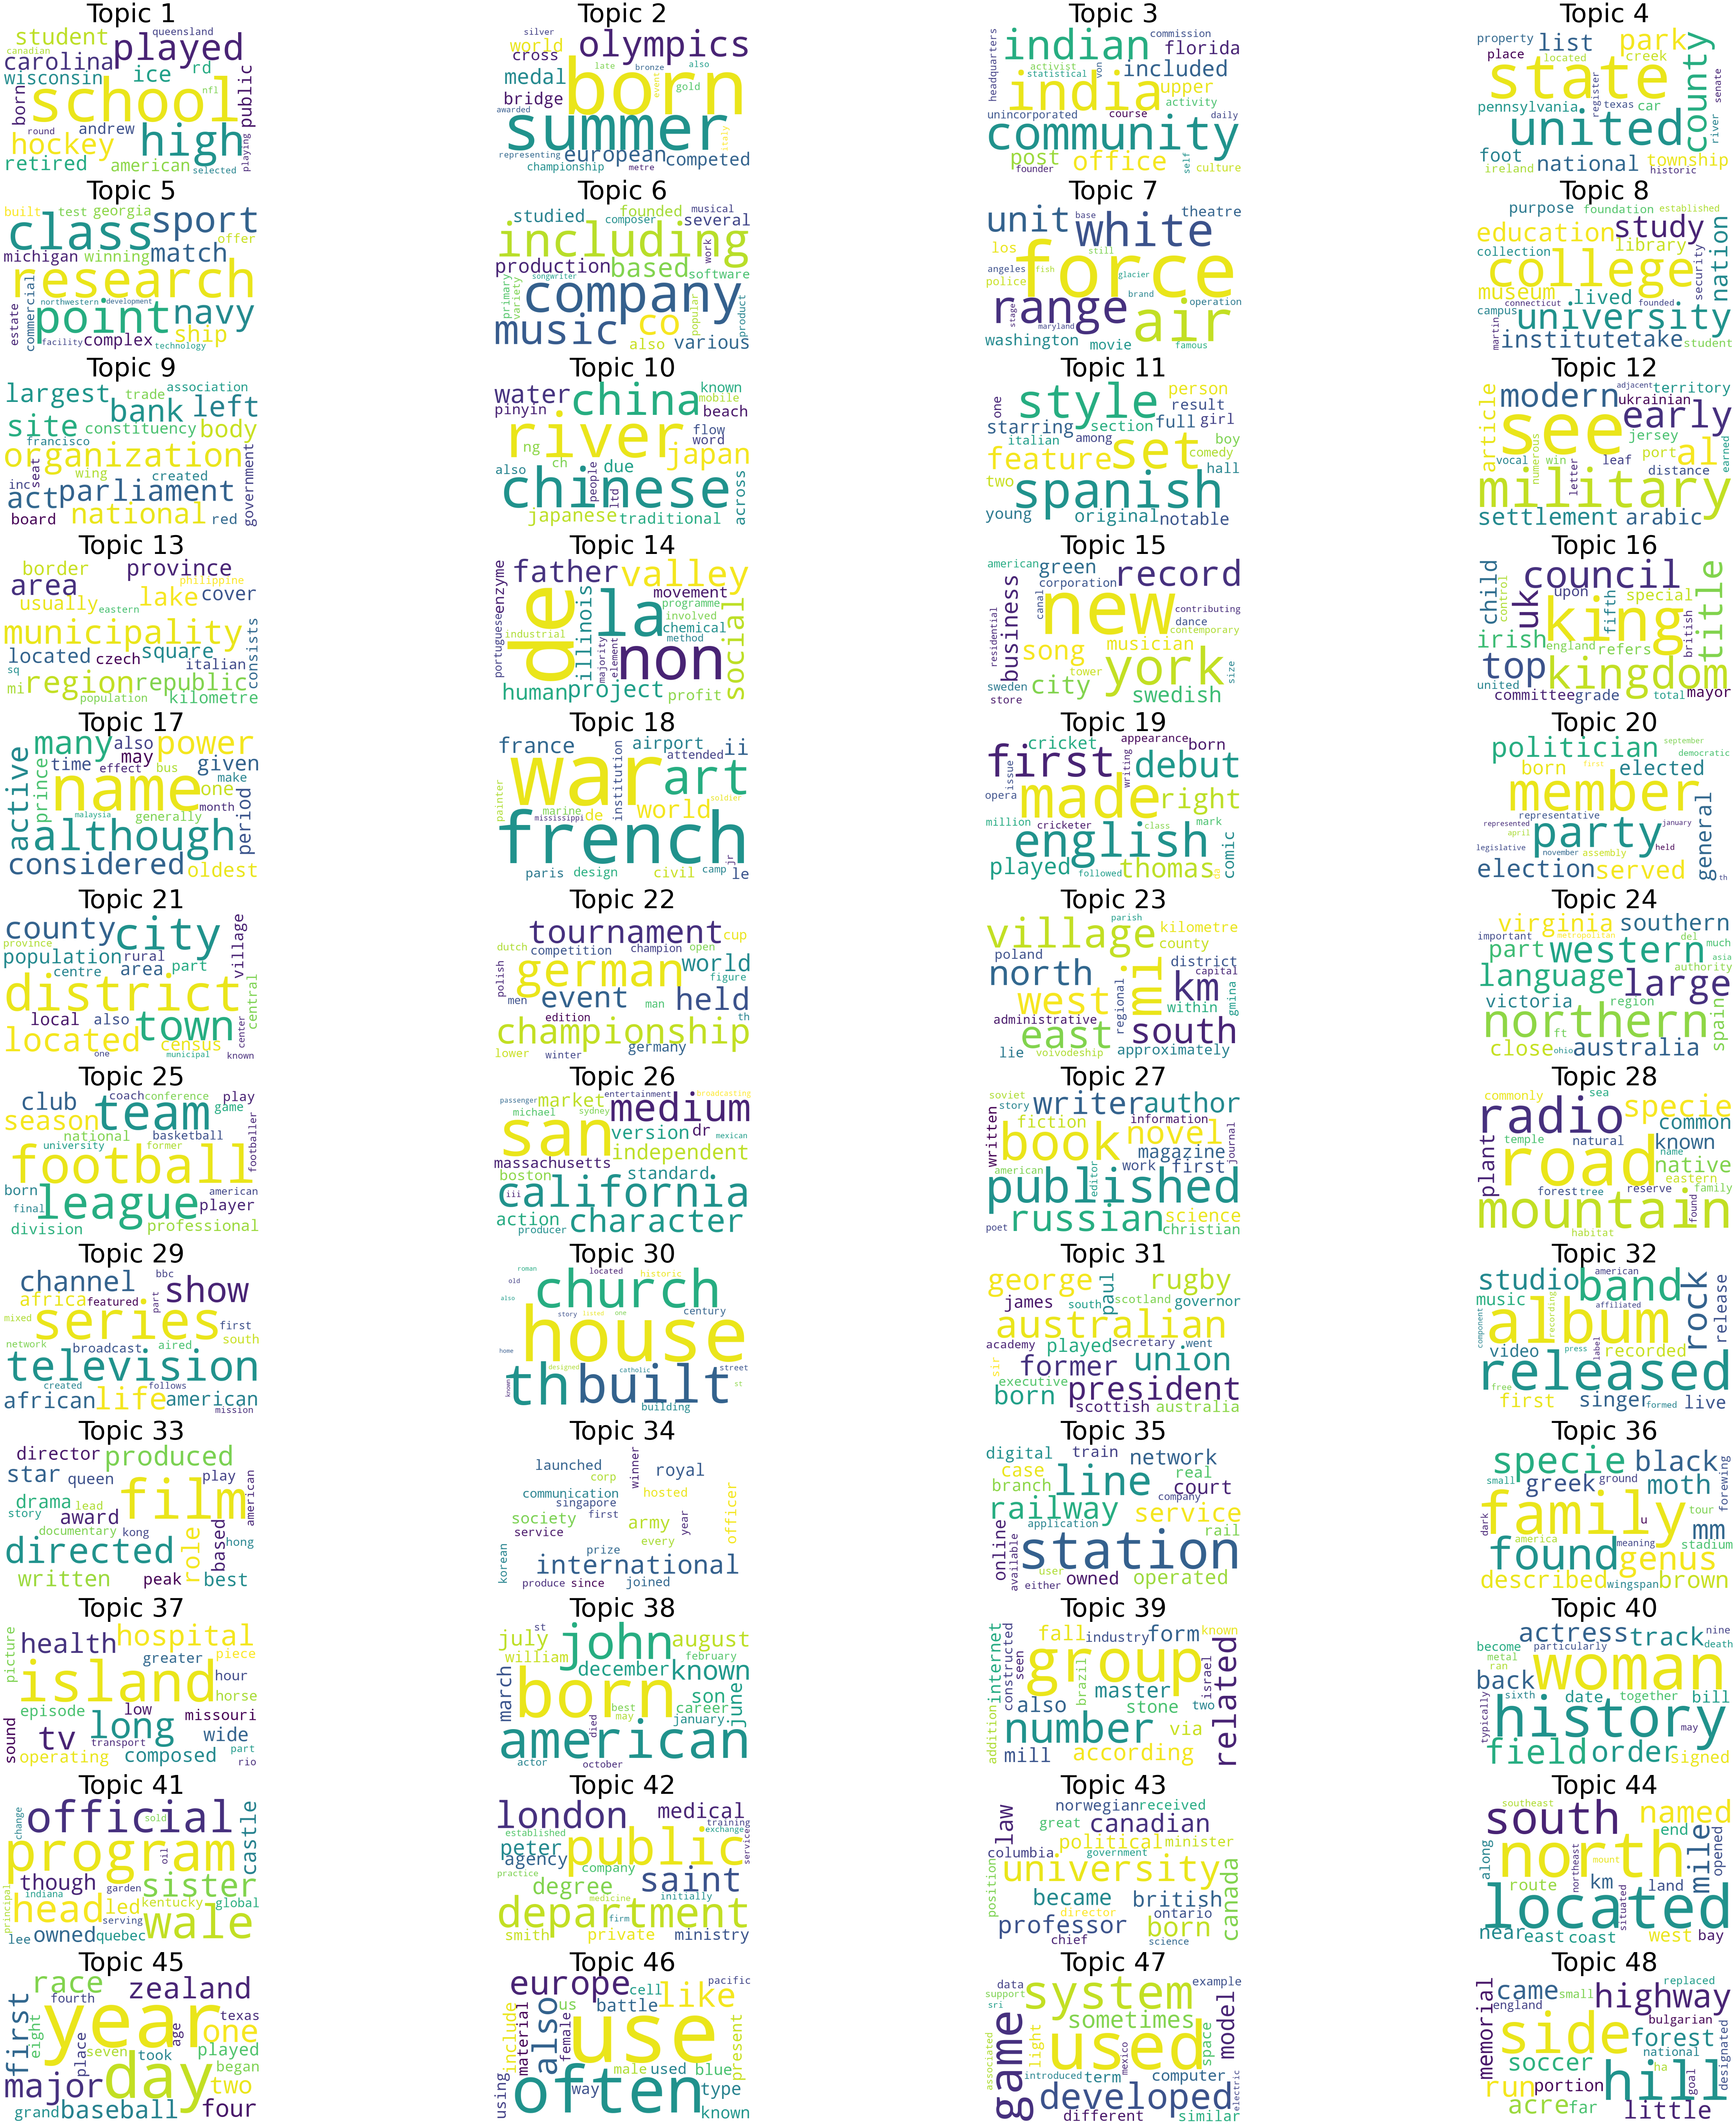

In [22]:
from wordcloud import WordCloud

fig, axs = plt.subplots(ncols=4, nrows=int(lda_model.num_topics/4), figsize=(80,80))
axs = axs.flatten()

for i, t in enumerate(range(lda_model.num_topics)): 
    topic_dict = dict(lda_model.show_topic(t, 20))
    im = WordCloud(
        width=800, height=460,
        #max_words = 20,
        background_color='white',
        random_state=0
    ).generate_from_frequencies(topic_dict)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t+1),fontsize=70)

plt.tight_layout()
plt.show()

### <font color='darkblue'>You can see some word which are relevant to the same topic already grouped together, for example:</font> 

1. topic 33 seems to be about films
2. topic 23 is about WW2
3. topic 8 seems to be about eduation and schools
4. topic 34 more about geograpich locations.

Please note that if you re-run the notebook with the same parameters the topic IDs will differ but the same words will cluster to form the same topic.

To improve the results:
* improve the data cleaning step. 
* we can tune the LDA model by trying different parameters for chunksize, passes, update_every, check the help manual for more details.
* Try different values for the `num_topics` parameter LdaModel. My current choice of `num_topics` was arbitrary.

